# Training a Neural Network via Pytorch

this notebook ilustrates how to build and train a neural network vis Pytorch using different optimizers

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import json
from tqdm import tqdm

## Load the data


## Extending the Neural Network with different Optimizers

In [25]:
training_set = torchvision.datasets.FashionMNIST('./data', train=True, download=True)
X_train, y_train = training_set.data, training_set.targets


validation_set = torchvision.datasets.FashionMNIST('./data', train=False, download=True)
X_val, y_val = validation_set.data, validation_set.targets

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2, random_state=42)


# Class labels
classes = np.array(training_set.classes)

In [26]:
print(f'The training set has shape {X_train.shape} with label shape {y_train.shape}.')

print(f'The validation set has shape {X_val.shape} with label shape {y_val.shape}.')

print(f'The test set has shape {X_test.shape} with label shape {y_test.shape}.')

print(f'There are the following classes in the data set {classes}.')

The training set has shape torch.Size([60000, 28, 28]) with label shape torch.Size([60000]).
The validation set has shape torch.Size([8000, 28, 28]) with label shape torch.Size([8000]).
The test set has shape torch.Size([2000, 28, 28]) with label shape torch.Size([2000]).
There are the following classes in the data set ['T-shirt/top' 'Trouser' 'Pullover' 'Dress' 'Coat' 'Sandal' 'Shirt'
 'Sneaker' 'Bag' 'Ankle boot'].


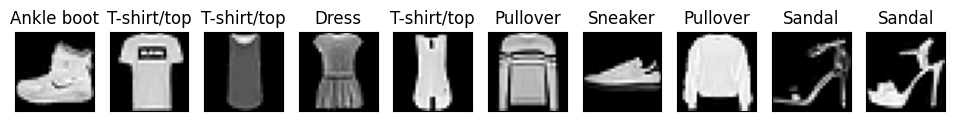

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(12,4), subplot_kw=dict(xticks=[], yticks=[]))
for i in np.arange(10):
    ax[i].imshow(X_train[i,:], cmap=plt.cm.gray)
    ax[i].set_title(classes[y_train[i]])

In [28]:
X_train = X_train / 255
X_train = torch.flatten(X_train, start_dim=1)

X_val = X_val / 255
X_val = torch.flatten(X_val, start_dim=1)

X_test = X_test / 255
X_test = torch.flatten(X_test, start_dim=1)

print(f'The training set now has the shape {X_train.shape}.')

print(f'The validation set now has the shape {X_val.shape}.')

print(f'The test set now has the shape {X_test.shape}.')

The training set now has the shape torch.Size([60000, 784]).
The validation set now has the shape torch.Size([8000, 784]).
The test set now has the shape torch.Size([2000, 784]).


In [30]:
# Your network class always needs to inherit from nn.Module.
class FeedForwardNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.bn1 = nn.BatchNorm1d(64)

        self.fc2 = nn.Linear(64, 32)
        self.dp2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(32, 32)
        self.bn3 = nn.BatchNorm1d(32)

        self.fc4 = nn.Linear(32, 10)
        self.sf = torch.nn.Softmax(1)

    # this method needs to be implement in order for your model to be called directly
    def forward(self, x):
        # Call your layers and activation fucntions here in the correct order.
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = self.dp2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)

        logits = self.fc4(x)
        prob = self.sf(logits)

        return logits, prob
    
    # implement in this function the training loop for your neural network
    # the overall idea of this trainin loop follows roughly the steps of the 
    # Gradient descent from Exercise 6
    def fit(self, X, y, X_val, y_val, optimizer, epochs = 25, batch_size = 32):
        # define the loss function
        loss_fn = torch.nn.CrossEntropyLoss()
        
        # define the optimizer
        # optimizer = torch.optim.SGD(self.parameters(), lr=eta, momentum=0.99)
        
        pbar = tqdm(range(epochs))

        losses = []
        accuracies_in = []
        accuracies_out = []

        for epoch in pbar:
            # get mini batches to iterate over in each epoch
            # they are already shuffled
            mini_batches = self.create_mini_batches(X, y, batch_size)

            mini_losses = []

            # iterate over the mini batches
            self.train()
            for mini_batch in mini_batches:
                X_mini, y_mini = mini_batch

                # Zero your gradients for every batch!
                optimizer.zero_grad()
                # make a forward pass to generate output and the computational graph
                y_hat, _ = self(X_mini)
                # calculate the loss 
                loss = loss_fn(y_hat, y_mini)
                # calculate the gradient
                loss.backward()
                # do an update step
                optimizer.step()

                mini_loss = loss.item()
                mini_losses.append(mini_loss)

            curr_loss = np.mean(mini_losses)
            curr_acc_in = self.accuracy(X, y)
            curr_acc_out = self.accuracy(X_val, y_val)

            losses.append(curr_loss)
            accuracies_in.append(curr_acc_in)
            accuracies_out.append(curr_acc_out)

            pbar.set_postfix({"loss": curr_loss, "acc_in": curr_acc_in, "acc_out": curr_acc_out})
            # pbar.set_postfix({"loss": curr_loss})
        self.eval()
        return losses, accuracies_in, accuracies_out
    
    def create_mini_batches(self, X, y, batch_size):
        mini_batches = []

        # create a random permutation of the data
        permutation =  np.random.permutation(X.shape[0])
        X_perm = X[permutation]
        y_perm = y[permutation]

        n_minibatches = X.shape[0] // batch_size
        # make sure that we get the last training instances if the data set
        # is not evenly divisible by the batch size
        if X.shape[0] % batch_size != 0:
            n_minibatches += 1


        for i in range(n_minibatches):
            lower = i * batch_size
            lower = min(lower, X.shape[0])
            upper = i * batch_size + batch_size
            upper = min(upper, X.shape[0])

            X_mini = X_perm[lower:upper, ]
            y_mini = y_perm[lower:upper]

            mini_batches.append((X_mini, y_mini))

        return mini_batches


    def accuracy(self, X, y):
        self.eval()
        with torch.no_grad():
            _, y_hat = self(X)
        y_ind = torch.argmax(y_hat, dim=1).numpy()
        percentage = np.mean(y_ind == y.numpy())
        return percentage

### Use the Momentum Optimizer

1. $$\textbf{m} \leftarrow \beta \textbf{m} - \eta\nabla_{\boldsymbol{\theta}} L(\boldsymbol{\theta})$$
2. $$\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \textbf{m}$$

In [31]:
model = FeedForwardNetwork()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.99)

losses, accuracies_in, accuracies_out = model.fit(X_train, y_train, X_val, y_val, optimizer, epochs=25, batch_size=128)

100%|██████████| 25/25 [00:20<00:00,  1.25it/s, loss=0.328, acc_in=0.9, acc_out=0.859]  


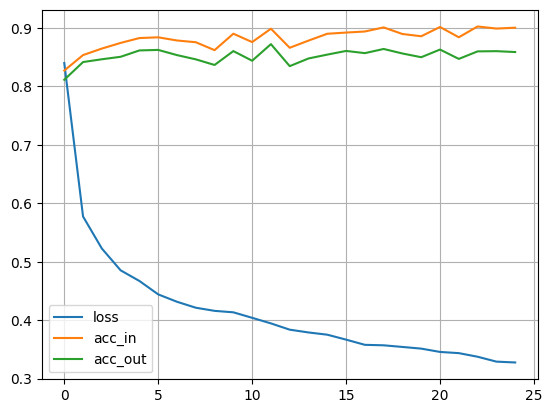

In [32]:
plt.plot(losses)
plt.plot(accuracies_in)
plt.plot(accuracies_out)

plt.grid(True)

plt.legend([
    "loss",
    "acc_in",
    "acc_out"
])

In [33]:
acc_train = model.accuracy(X_train, y_train)
acc_val = model.accuracy(X_val, y_val)
acc_test = model.accuracy(X_test, y_test)

print(f'The model has a training (in sample) accuracy of {acc_train}')
print(f'The model has a validation accuracy of {acc_val}')
print(f'The model has a test accuracy of {acc_test}')

The model has a training (in sample) accuracy of 0.9003833333333333
The model has a validation accuracy of 0.85875
The model has a test accuracy of 0.864


### Use the RMSProp optimizer

1. $$\textbf{s} \leftarrow \alpha \textbf{s} + (1 - \alpha) \nabla_{\boldsymbol{\theta}} L(\boldsymbol{\theta})^2$$
2. $$\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} - \eta\nabla_{\boldsymbol{\theta}} L(\boldsymbol{\theta}) / \sqrt{\textbf{s} + \varepsilon}$$

In [34]:
model = FeedForwardNetwork()

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)

losses, accuracies_in, accuracies_out = model.fit(X_train, y_train, X_val, y_val, optimizer, epochs=25, batch_size=128)

100%|██████████| 25/25 [00:21<00:00,  1.17it/s, loss=0.303, acc_in=0.899, acc_out=0.854]


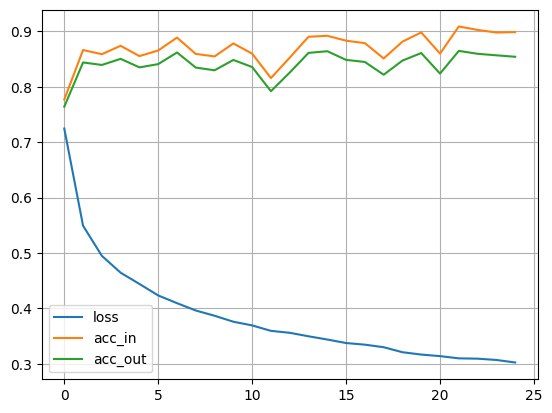

In [35]:
plt.plot(losses)
plt.plot(accuracies_in)
plt.plot(accuracies_out)

plt.grid(True)

plt.legend([
    "loss",
    "acc_in",
    "acc_out"
])

In [36]:
acc_train = model.accuracy(X_train, y_train)
acc_val = model.accuracy(X_val, y_val)
acc_test = model.accuracy(X_test, y_test)

print(f'The model has a training (in sample) accuracy of {acc_train}')
print(f'The model has a validation accuracy of {acc_val}')
print(f'The model has a test accuracy of {acc_test}')

The model has a training (in sample) accuracy of 0.8986
The model has a validation accuracy of 0.854125
The model has a test accuracy of 0.858


### Use the Adam optimizer

1. $$\textbf{m} \leftarrow \beta_{1} \textbf{m} - (1 - \beta_{1}) \nabla_{\boldsymbol{\theta}} L(\boldsymbol{\theta})$$
2. $$\textbf{s} \leftarrow \beta_{2} \textbf{s} + (1 - \beta_{2}) \nabla_\theta L(\boldsymbol{\theta})^2$$
3. $$\widehat{\textbf{m}} \leftarrow \frac{\textbf{m}}{1 - \beta_{1}^{t}}$$
4. $$\widehat{\textbf{s}} \leftarrow \frac{\textbf{s}}{1 - \beta_{2}^{t}}$$
5. $$\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \eta\widehat{\textbf{m}} / \sqrt{\widehat{\textbf{s}} + \varepsilon}$$

In [40]:
model = FeedForwardNetwork()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

losses, accuracies_in, accuracies_out = model.fit(X_train, y_train, X_val, y_val, optimizer, epochs=25, batch_size=128)

100%|██████████| 25/25 [00:22<00:00,  1.11it/s, loss=0.316, acc_in=0.919, acc_out=0.87] 


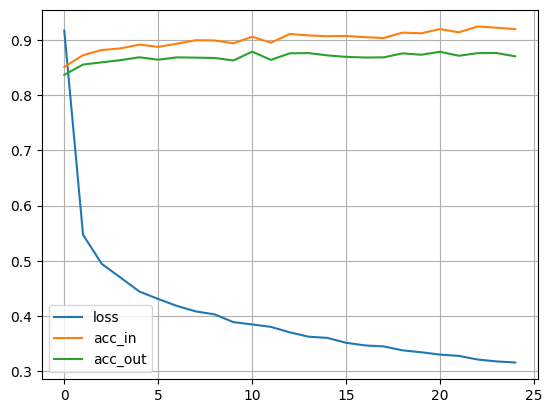

In [41]:
plt.plot(losses)
plt.plot(accuracies_in)
plt.plot(accuracies_out)

plt.grid(True)

plt.legend([
    "loss",
    "acc_in",
    "acc_out"
])

In [42]:
acc_train = model.accuracy(X_train, y_train)
acc_val = model.accuracy(X_val, y_val)
acc_test = model.accuracy(X_test, y_test)

print(f'The model has a training (in sample) accuracy of {acc_train}')
print(f'The model has a validation accuracy of {acc_val}')
print(f'The model has a test accuracy of {acc_test}')

The model has a training (in sample) accuracy of 0.9192833333333333
The model has a validation accuracy of 0.87
The model has a test accuracy of 0.8705


### Train the Nerual Network on a GPU 🎉

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device = torch.device(torch.device("cuda:0") if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# Your network class always needs to inherit from nn.Module.
class FeedForwardNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 256)
        self.dp2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 128)
        self.dp4 = nn.Dropout(0.5)

        self.fc5 = nn.Linear(128, 64)
        self.bn5 = nn.BatchNorm1d(64)

        self.fc6 = nn.Linear(64, 32)
        self.bn6 = nn.BatchNorm1d(32)

        self.fc7 = nn.Linear(32, 10)
        self.sf = torch.nn.Softmax(1)

    # this method needs to be implement in order for your model to be called directly
    def forward(self, x):
        # Call your layers and activation fucntions here in the correct order.
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = self.dp2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.fc4(x)
        x = self.dp4(x)
        x = F.relu(x)

        x = self.fc5(x)
        x = self.bn5(x)
        x = F.relu(x)

        x = self.fc6(x)
        x = self.bn6(x)
        x = F.relu(x)

        logits = self.fc7(x)
        prob = self.sf(logits)

        return logits, prob
    
    # implement in this function the training loop for your neural network
    # the overall idea of this trainin loop follows roughly the steps of the 
    # Gradient descent from Exercise 6
    def fit(self, X, y, X_val, y_val, optimizer, epochs = 25, batch_size = 32):
        # define the loss function
        loss_fn = torch.nn.CrossEntropyLoss()
        
        # define the optimizer
        # optimizer = torch.optim.SGD(self.parameters(), lr=eta, momentum=0.99)
        
        pbar = tqdm(range(epochs))

        losses = []
        accuracies_in = []
        accuracies_out = []

        for epoch in pbar:
            # get mini batches to iterate over in each epoch
            # they are already shuffled
            mini_batches = self.create_mini_batches(X, y, batch_size)

            mini_losses = []

            # iterate over the mini batches
            self.train()
            for mini_batch in mini_batches:
                X_mini, y_mini = mini_batch

                # Zero your gradients for every batch!
                optimizer.zero_grad()
                # make a forward pass to generate output and the computational graph
                y_hat, _ = self(X_mini)
                # calculate the loss 
                loss = loss_fn(y_hat, y_mini)
                # calculate the gradient
                loss.backward()
                # do an update step
                optimizer.step()

                # GPU modified
                mini_loss = loss.cpu().item()
                mini_losses.append(mini_loss)

            curr_loss = np.mean(mini_losses)
            curr_acc_in = self.accuracy(X, y)
            curr_acc_out = self.accuracy(X_val, y_val)

            losses.append(curr_loss)
            accuracies_in.append(curr_acc_in)
            accuracies_out.append(curr_acc_out)

            pbar.set_postfix({"loss": curr_loss, "acc_in": curr_acc_in, "acc_out": curr_acc_out})
            # pbar.set_postfix({"loss": curr_loss})
        self.eval()
        return losses, accuracies_in, accuracies_out
    
    def create_mini_batches(self, X, y, batch_size):
        mini_batches = []

        # create a random permutation of the data
        permutation =  np.random.permutation(X.shape[0])
        X_perm = X[permutation]
        y_perm = y[permutation]

        n_minibatches = X.shape[0] // batch_size
        # make sure that we get the last training instances if the data set
        # is not evenly divisible by the batch size
        if X.shape[0] % batch_size != 0:
            n_minibatches += 1


        for i in range(n_minibatches):
            lower = i * batch_size
            lower = min(lower, X.shape[0])
            upper = i * batch_size + batch_size
            upper = min(upper, X.shape[0])

            X_mini = X_perm[lower:upper, ]
            y_mini = y_perm[lower:upper]

            mini_batches.append((X_mini, y_mini))

        return mini_batches


    def accuracy(self, X, y):
        self.eval()
        with torch.no_grad():
            _, y_hat = self(X)
        # GPU modified
        y_ind = torch.argmax(y_hat.cpu(), dim=1).numpy()
        percentage = np.mean(y_ind == y.cpu().numpy())
        return percentage

In [ ]:
model = FeedForwardNetwork()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

X_train = X_train.to(device)
y_train = y_train.to(device)
X_val = X_val.to(device)
y_val = y_val.to(device)
#X_train = X_train.cpu()
#y_train = y_train.cpu()
#X_val = X_val.cpu()
#y_val = y_val.cpu()

losses, accuracies_in, accuracies_out = model.fit(X_train, y_train, X_val, y_val, optimizer, epochs=25, batch_size=128)

In [ ]:
plt.plot(losses)
plt.plot(accuracies_in)
plt.plot(accuracies_out)

plt.grid(True)

plt.legend([
    "loss",
    "acc_in",
    "acc_out"
])

In [ ]:
model.cpu()
X_train = X_train.cpu()
y_train = y_train.cpu()
X_val = X_val.cpu()
y_val = y_val.cpu()

acc_train = model.accuracy(X_train, y_train)
acc_val = model.accuracy(X_val, y_val)
acc_test = model.accuracy(X_test, y_test)

print(f'The model has a training (in sample) accuracy of {acc_train}')
print(f'The model has a validation accuracy of {acc_val}')
print(f'The model has a test accuracy of {acc_test}')